# Install Dependencies

In [203]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [22]:
!pip install requests

In [23]:
!pwd

/content


In [47]:
import requests
import json
import base64
import pandas as pd
from io import StringIO

# Load Data

In [205]:
def parse_request(response,write=False,file='downloaded_file'):
    """
    Loads a base64 encoded file.

    Input: response (type:json) - file to decode
          write (type:bool) - optional flag for saving file
          filename (type:str) - optional flag for saving file name
    Output: decoded_file (type:bytes)
    """
    # Parse the JSON response
    response_json = response.json()

    # Check if the response contains a 'file' key with a base64 encoded value
    if 'file' in response_json:
        base64_encoded_file = response_json['file']

        # Decode the base64 encoded file
        decoded_file = base64.b64decode(base64_encoded_file)

        if write:
          # Save the decoded file to a local file
          with open(file, 'wb') as f:
              f.write(decoded_file)

          print("Base64 encoded file downloaded and saved to 'downloaded_file'")

    else:
        print("No base64 encoded file found in the response.")

    return decoded_file

In [37]:
def post_request(url,data,auth_key):
    """
    Uses a provided auth key to authenticate to an endpoint

    Input: url (type:string) - endpoint address
           data (type:dict) - username in format {"email":user_email}
           auth_key (type:auth2_key) - endpoint auth key using OAuth 2.0 format
    Output: response (type:requests.models.Response) - output from requests
    """
    # Set the 'Authorization' header with the authentication key in OAuth2 format
    headers = {
        'Authorization': f"Bearer {auth_key}",
        'Content-Type': 'application/json'
    }

    try:
        # Send the POST request with JSON data and authentication key
        response = requests.post(url, headers=headers, data=json.dumps(data))

        # Check if the request was successful
        if response.status_code == 200:
            print("POST request successful.")
            print("Response:", response.text)
        else:
            print("POST request failed.")
            print("Status Code:", response.status_code)
            print("Response:", response.text)

    except requests.exceptions.RequestException as e:
        print("An error occurred:", e)

    return response

In [ ]:
# Enter details
url = "" # Define the API endpoint URL
data = {"email": "user@gmail.com"} # Define the JSON input data
auth_key = "" # Define the authentication key

# Call the post function to send the POST request
response = post_request(url,data,auth_key)

In [207]:
# Call the parse function to decode the file
data = parse_request(response,write=True)

Base64 encoded file downloaded and saved to 'downloaded_file'


In [40]:
# Check data file
print(type(data))

<class 'bytes'>


# Format Data

In [51]:
# Read data file from tsv
data_str = data.decode('utf-8')
df = pd.read_csv(StringIO(data_str), delimiter='\t')

# Display the DataFrame
df.head()

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
0,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:40,Login Attempt,NaN,NaN,198.51.100.44
1,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:42,Add second email,Email,grace.kim@healthcare.com,198.51.100.44
2,Jane Doe,jane.doe@hotmail.com,+1-202-555-6789,"456 Oak St, Seattle, WA",2024-12-01 03:16,Login Attempt,NaN,NaN,109.201.127.2
3,David Lee,david.lee@gmail.com,+1-415-555-8901,"654 Elm St, San Francisco",2024-12-01 03:30,Login Attempt,NaN,NaN,109.201.127.2
4,Jane Doe,jane.doe@hotmail.com,+1-512-555-1234,"456 Oak St, Seattle, WA",2024-12-01 03:35,Profile Update,Email,h1234llk@gmail.com,149.62.55.55


In [53]:
# Summarize DataFrame
df.describe()

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
count,13,13,13,13,13,13,6,6,13
unique,9,10,11,9,13,5,4,6,8
top,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:40,Profile Update,Email,grace.kim@healthcare.com,198.51.100.44
freq,3,2,3,3,1,5,3,1,3


# Visualize Data

In [99]:
# Load visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

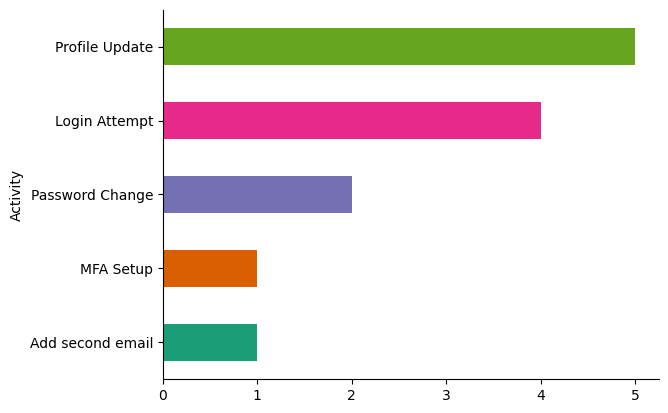

In [59]:
# Note 1: Check Activity Counts for common actions taken by user
df.groupby('Activity').size().sort_values(ascending=True).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

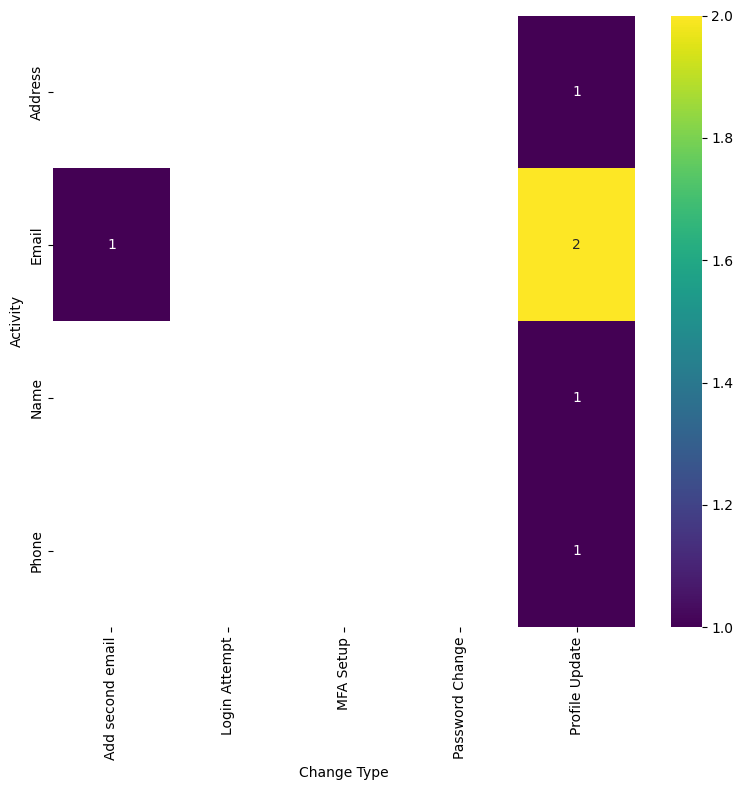

In [63]:
# Note 2: Check Activity by Change Type Counts for common data elements changed by a user for a specific action
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Change Type'].value_counts()
    for x_label, grp in df.groupby('Activity')
})
sns.heatmap(df_2dhist, cmap='viridis', annot=True)
plt.xlabel('Change Type')
_ = plt.ylabel('Activity')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [70]:
# Show the original email vs the added email. We see that Grace added a second email grace.kim@healthcare.com and used that to login 15 hr later
# IP address 198.51.100.44 is Boston
#df[(df['Activity'] == 'Add second email') & (df['Changed Value'].notna())]
df[(df['Name'] == 'Grace Kim')]

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
0,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:40,Login Attempt,NaN,NaN,198.51.100.44
1,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:42,Add second email,Email,grace.kim@healthcare.com,198.51.100.44
12,Grace Kim,grace.kim@healthcare.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 16:42,Login Attempt,NaN,NaN,198.51.100.44


In [71]:
# Show the profile updates. We see the 2 email update, 1 address/phone/name change
df[(df['Activity'] == 'Profile Update')]

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
4,Jane Doe,jane.doe@hotmail.com,+1-512-555-1234,"456 Oak St, Seattle, WA",2024-12-01 03:35,Profile Update,Email,h1234llk@gmail.com,149.62.55.55
7,Bob Brown,bob.brown@gmail.com,+1-303-678-9012,"111 Maple St, Boulder, CO",2024-12-01 11:20,Profile Update,Email,bob.b@mailinator.com,45.63.12.54
8,Alice Johnson,alice.j@gmail.com,+1-512-987-6543,"789 Pine St, Austin, TX",2024-12-01 12:30,Profile Update,Address,"PO Box 456; Birch St, Boston, MA",45.63.12.54
10,Frank Harris,frank.h@example.com,+1-213-555-6789,"555 Cedar St, Los Angeles",2024-12-01 14:40,Profile Update,Phone,+7-495-555-5678,54.22.4.6
11,Carol White,carol.white@example.com,+1-773-555-5678,"202 Birch St, Chicago, IL",2024-12-01 15:25,Profile Update,Name,Carol Smith,184.154.83.119


In [76]:
# Check Jane Doe's email update. She changed her email to a strange email from a different IP address + Phone 19 minutes later. Should block this contact based on foreign IP and mismatched phone area code
## Area code is 202 is Washington DC. IP Address 109.201.127.2 is Kovrov, Moscow
## Area Code 512 is Austin TX. IP Address 149.62.55.55 is Moscow
## This looks malicious
display(df[(df['Name'] == 'Jane Doe')])
display(df[(df['Email'] == 'h1234llk@gmail.com')])

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
2,Jane Doe,jane.doe@hotmail.com,+1-202-555-6789,"456 Oak St, Seattle, WA",2024-12-01 03:16,Login Attempt,NaN,NaN,109.201.127.2
4,Jane Doe,jane.doe@hotmail.com,+1-512-555-1234,"456 Oak St, Seattle, WA",2024-12-01 03:35,Profile Update,Email,h1234llk@gmail.com,149.62.55.55


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address


In [79]:
# Check Bob Brown's email update. He changed his email from IP Address 45.63.12.54 in New Jersey. Should increase the friction of this contact based on IP distance from home with MFA
display(df[(df['Name'] == 'Bob Brown')])
display(df[(df['Email'] == 'bob.b@mailinator.com	')])

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
7,Bob Brown,bob.brown@gmail.com,+1-303-678-9012,"111 Maple St, Boulder, CO",2024-12-01 11:20,Profile Update,Email,bob.b@mailinator.com,45.63.12.54


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address


In [86]:
# Check Alice's Address. She changed her address to a PO Box in Boston from Austin, from the same IP as Bob 1hr later. Should block this contact based on IP overlap, address change, and IP-address mismatch
# This could be malicious, or false positive from a VPN hub / related to Bob
display(df[(df['Name'] == 'Alice Johnson')])
display(df[(df['Address'] == 'PO Box 456; Birch St, Boston, MA')])
display(df[(df['IP Address'] == '45.63.12.54')])

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
8,Alice Johnson,alice.j@gmail.com,+1-512-987-6543,"789 Pine St, Austin, TX",2024-12-01 12:30,Profile Update,Address,"PO Box 456; Birch St, Boston, MA",45.63.12.54


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
7,Bob Brown,bob.brown@gmail.com,+1-303-678-9012,"111 Maple St, Boulder, CO",2024-12-01 11:20,Profile Update,Email,bob.b@mailinator.com,45.63.12.54
8,Alice Johnson,alice.j@gmail.com,+1-512-987-6543,"789 Pine St, Austin, TX",2024-12-01 12:30,Profile Update,Address,"PO Box 456; Birch St, Boston, MA",45.63.12.54


In [88]:
# Check Frank's Phone. +7 is Russian area code. IP Address 54.22.4.6 is Seattle. Should block this contact based on home address and IP-address mismatch
# This looks malicious
display(df[(df['Name'] == 'Frank Harris')])
display(df[(df['Phone'] == '+7-495-555-5678	')])

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
10,Frank Harris,frank.h@example.com,+1-213-555-6789,"555 Cedar St, Los Angeles",2024-12-01 14:40,Profile Update,Phone,+7-495-555-5678,54.22.4.6


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address


In [90]:
# Check Carol's Phone. This looks like a normal last name change
display(df[(df['Name'] == 'Carol White')])
display(df[(df['Name'] == 'Carol Smith')])

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address
11,Carol White,carol.white@example.com,+1-773-555-5678,"202 Birch St, Chicago, IL",2024-12-01 15:25,Profile Update,Name,Carol Smith,184.154.83.119


,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address


# Enrich Data

In [91]:
# We want to enrich the original data with IP geo
def get_ip_geolocation(ip_address):
    url = f"http://ip-api.com/json/{ip_address}"
    response = requests.get(url)
    data = response.json()
    return data['country'], data['city'], data['region']

In [120]:
# Enrich the data with IP geo
df2 = df.copy()
df2[['IP Address Country', 'IP Address City', 'IP Address Region']] = df['IP Address'].apply(lambda x: pd.Series(get_ip_geolocation(x)))

In [121]:
# Check data
df2.head()

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address,IP Address Country,IP Address City,IP Address Region
0,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:40,Login Attempt,NaN,NaN,198.51.100.44,Romania,Bucharest,B
1,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:42,Add second email,Email,grace.kim@healthcare.com,198.51.100.44,Romania,Bucharest,B
2,Jane Doe,jane.doe@hotmail.com,+1-202-555-6789,"456 Oak St, Seattle, WA",2024-12-01 03:16,Login Attempt,NaN,NaN,109.201.127.2,Russia,Kovrov,VLA
3,David Lee,david.lee@gmail.com,+1-415-555-8901,"654 Elm St, San Francisco",2024-12-01 03:30,Login Attempt,NaN,NaN,109.201.127.2,Russia,Kovrov,VLA
4,Jane Doe,jane.doe@hotmail.com,+1-512-555-1234,"456 Oak St, Seattle, WA",2024-12-01 03:35,Profile Update,Email,h1234llk@gmail.com,149.62.55.55,Russia,Kubinka,MOS


In [101]:
! pip install pgeocode

In [137]:
! pip install phonenumbers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.3 MB/s eta 0:00:00


In [138]:
import pgeocode
import phonenumbers
from phonenumbers import geocoder
import re

In [150]:
# We want to enrich the original data with phone area code
def get_area_code(phone_number):
    match = re.search(r'\d{3}', phone_number)
    if match:
        return match.group()
    else:
        return None

def convert_area_code(phone_number):
    try:
        # Parse the phone number
        x = phonenumbers.parse(phone_number, None)

        # Get the location
        location = geocoder.description_for_number(x, "en")

        return location

    except Exception as e:
        return str(e)

In [151]:
# Enrich the data with phone area code
df2['Area Code'] = df2['Phone'].apply(get_area_code)
df2['Location'] = df2['Phone'].apply(convert_area_code)

In [152]:
df2.head()

,Name,Email,Phone,Address,Timestamp (MT),Activity,Change Type,Changed Value,IP Address,IP Address Country,IP Address City,IP Address Region,Area Code,Location
0,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:40,Login Attempt,NaN,NaN,198.51.100.44,Romania,Bucharest,B,617,Massachusetts
1,Grace Kim,grace.kim@gmail.com,+1-617-555-2345,"789 Pine St, Boston, MA",2024-12-01 01:42,Add second email,Email,grace.kim@healthcare.com,198.51.100.44,Romania,Bucharest,B,617,Massachusetts
2,Jane Doe,jane.doe@hotmail.com,+1-202-555-6789,"456 Oak St, Seattle, WA",2024-12-01 03:16,Login Attempt,NaN,NaN,109.201.127.2,Russia,Kovrov,VLA,202,Washington D.C.
3,David Lee,david.lee@gmail.com,+1-415-555-8901,"654 Elm St, San Francisco",2024-12-01 03:30,Login Attempt,NaN,NaN,109.201.127.2,Russia,Kovrov,VLA,415,"San Francisco, CA"
4,Jane Doe,jane.doe@hotmail.com,+1-512-555-1234,"456 Oak St, Seattle, WA",2024-12-01 03:35,Profile Update,Email,h1234llk@gmail.com,149.62.55.55,Russia,Kubinka,MOS,512,Texas


# Automate Detection

In [186]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the DataFrame
dfModel = df2.copy()

# Define the categorical and numerical columns
#categorical_cols = ['Name', 'Email', 'Address', 'Activity', 'Change Type', 'IP Address Country', 'IP Address City', 'IP Address Region', 'Location']
#numerical_cols = ['Phone', 'Area Code']
categorical_cols = ['Email', 'Address', 'Activity', 'Change Type', 'IP Address Country', 'Location']
numerical_cols = ['Area Code']

# Convert the 'Phone' column to integer by removing the non-numeric characters
dfModel['Phone'] = dfModel['Phone'].str.replace('+1-', '').str.replace('-', '').astype(int)

# Convert the 'Timestamp (MT)' column to datetime and extract the hour and minute
dfModel['Timestamp (MT)'] = pd.to_datetime(dfModel['Timestamp (MT)'])
dfModel['Hour'] = dfModel['Timestamp (MT)'].dt.hour
dfModel['Minute'] = dfModel['Timestamp (MT)'].dt.minute

# Drop the 'Timestamp (MT)' column
dfModel = dfModel.drop('Timestamp (MT)', axis=1)

# Apply LabelEncoder to each categorical column
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    dfModel[col] = le.fit_transform(dfModel[col])
    encoders[col] = le

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        #('num', StandardScaler(), ['Hour', 'Minute', 'Area Code', 'Phone'])
        ('num', StandardScaler(), ['Hour', 'Area Code'])
    ]
)

# Define the Isolation Forest model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('isolation_forest', IsolationForest(contamination=0.50, random_state=0))
])

# Split the data into features and target
X = dfModel.drop(['Changed Value'], axis=1)

# Fit the model to the data
model.fit(X)

# Predict the anomalies
predictions = model.predict(X)

# Create a new column in the DataFrame to store the anomaly predictions
dfModel['anomaly'] = predictions

# Print the DataFrame with the anomaly predictions
display(dfModel)

# Print the anomalies
print("Anomalies:")
display(dfModel[dfModel['anomaly'] == -1])

# Print the anomalies decoded
print("Anomalies Decoded:")
anomalies = dfModel[dfModel['anomaly'] == -1]
for index, row in anomalies.iterrows():
    for col in categorical_cols:
        row[col] = encoders[col].inverse_transform([row[col]])[0]
    print(row)

,Name,Email,Phone,Address,Activity,Change Type,Changed Value,IP Address,IP Address Country,IP Address City,IP Address Region,Area Code,Location,Hour,Minute,anomaly
0,Grace Kim,6,6175552345,8,1,4,NaN,198.51.100.44,0,Bucharest,B,617,5,1,40,-1
1,Grace Kim,6,6175552345,8,0,1,grace.kim@healthcare.com,198.51.100.44,0,Bucharest,B,617,5,1,42,-1
2,Jane Doe,8,2025556789,4,1,4,NaN,109.201.127.2,1,Kovrov,VLA,202,8,3,16,-1
3,David Lee,3,4155558901,6,1,4,NaN,109.201.127.2,1,Kovrov,VLA,415,6,3,30,1
4,Jane Doe,8,5125551234,4,4,1,h1234llk@gmail.com,149.62.55.55,1,Kubinka,MOS,512,7,3,35,1
5,John Smith,9,3035559876,1,2,4,NaN,104.28.14.45,2,Washington,DC,303,2,11,32,1
6,John Smith,9,3035551234,1,3,4,NaN,104.28.14.45,2,Washington,DC,303,2,11,15,1
7,Bob Brown,1,3036789012,0,4,1,bob.b@mailinator.com,45.63.12.54,2,Piscataway,NJ,303,3,11,20,1
8,Alice Johnson,0,5129876543,7,4,0,"PO Box 456; Birch St, Boston, MA",45.63.12.54,2,Piscataway,NJ,512,7,12,30,1
9,Eve Johnson,4,6025554321,3,3,4,NaN,70.174.219.67,2,San Tan Valley,AZ,602,0,13,31,1


Anomalies:


,Name,Email,Phone,Address,Activity,Change Type,Changed Value,IP Address,IP Address Country,IP Address City,IP Address Region,Area Code,Location,Hour,Minute,anomaly
0,Grace Kim,6,6175552345,8,1,4,NaN,198.51.100.44,0,Bucharest,B,617,5,1,40,-1
1,Grace Kim,6,6175552345,8,0,1,grace.kim@healthcare.com,198.51.100.44,0,Bucharest,B,617,5,1,42,-1
2,Jane Doe,8,2025556789,4,1,4,NaN,109.201.127.2,1,Kovrov,VLA,202,8,3,16,-1
10,Frank Harris,5,2135556789,5,4,3,+7-495-555-5678,54.22.4.6,2,Seattle,WA,213,4,14,40,-1
11,Carol White,2,7735555678,2,4,2,Carol Smith,184.154.83.119,2,Norcross,GA,773,1,15,25,-1
12,Grace Kim,7,6175552345,8,1,4,NaN,198.51.100.44,0,Bucharest,B,617,5,16,42,-1


Anomalies Decoded:
Name                                Grace Kim
Email                     grace.kim@gmail.com
Phone                              6175552345
Address               789 Pine St, Boston, MA
Activity                        Login Attempt
Change Type                               NaN
Changed Value                             NaN
IP Address                      198.51.100.44
IP Address Country                    Romania
IP Address City                     Bucharest
IP Address Region                           B
Area Code                                 617
Location                        Massachusetts
Hour                                        1
Minute                                     40
anomaly                                    -1
Name: 0, dtype: object
Name                                 Grace Kim
Email                      grace.kim@gmail.com
Phone                               6175552345
Address                789 Pine St, Boston, MA
Activity                      Add 

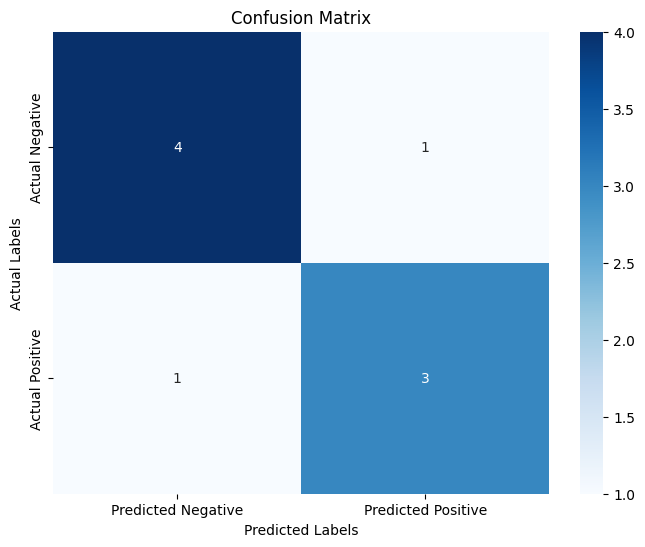

In [201]:
# True Positive: Jane, Frank, Grace
# False Positive: Carol
# False Negative: David
# True Negative: Bob, Alice, John, Eve

# Accuracy: (TP + TN) / All = 77%
# Precision: TP / (TP + FN) = 75%
# Recall: TP / (TP + FP) = 75%
# F1-Score: 2 * (Precision * Recall) / (Precision + Recall) = 75%

# Calculate true positives, false positives, true negatives, and false negatives
total_samples = 9
tp = 3
tn = 4
fp = 1
fn = 1

# Create a confusion matrix
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.0f',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# Set title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

# Show the plot
plt.show()

# End of Notebook